In [1]:
import atlite
import geopandas as gpd

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import os
from matplotlib.gridspec import GridSpec
#import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from cartopy.crs import PlateCarree as plate

import xarray as xr

import logging
import warnings

import numpy as np

import matplotlib.patheffects as path_effects

import yaml
import pickle

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

# Load Geodata
load you regions to which you want to aggregate the wind speeds from the "input_data" folder

In [2]:
dirname = os.getcwd()
dirname = os.path.join(dirname, '..') #go one folder up to main dir of tool


with open(os.path.join(dirname, "configs/config.yaml"), "r", encoding="utf-8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)  

weather_year = config['weather_year']
study_region_name = config['study_region_name']
region_name_clean = study_region_name
#region_name_clean = clean_region_name(study_region_name) 
data_path = os.path.join(dirname, 'data', region_name_clean)

# Load the CRS
# geo CRS
with open(os.path.join(data_path, region_name_clean+'_global_CRS.pkl'), 'rb') as file:
        global_crs_obj = pickle.load(file)
# projected CRS
with open(os.path.join(data_path, region_name_clean+'_local_CRS.pkl'), 'rb') as file:
        local_crs_obj = pickle.load(file)
# Extract tag for filename, e.g., 'EPSG3035' or 'ESRI102003'
auth = global_crs_obj.to_authority()
global_crs_tag = ''.join(auth) if auth else global_crs_obj.to_string().replace(":", "_")
auth = local_crs_obj.to_authority()
local_crs_tag = ''.join(auth) if auth else local_crs_obj.to_string().replace(":", "_")

regionPath = os.path.join(data_path, f'{region_name_clean}_{global_crs_tag}.geojson')
region = gpd.read_file(regionPath)


# Load and process the cutout

In [4]:
#load cutout 
cutout = atlite.Cutout(os.path.join(data_path,f"{region_name_clean}-{weather_year}-era5.nc"))

#access cutout data
cutout.data

<xarray.Dataset> Size: 11MB
Dimensions:               (x: 5, y: 4, time: 8760)
Coordinates:
  * x                     (x) float64 40B 13.0 13.25 13.5 13.75 14.0
  * y                     (y) float64 32B 51.25 51.5 51.75 52.0
  * time                  (time) datetime64[ns] 70kB 1990-01-01 ... 1990-12-3...
    lon                   (x) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    lat                   (y) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
Data variables: (12/13)
    wnd100m               (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    wnd_shear_exp         (time, y, x) float64 1MB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    wnd_azimuth           (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    roughness             (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    influx_toa            (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    influx_direct         (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    ...                    ...
    albedo                (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    solar_altitude        (time, y, x) float64 1MB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    solar_azimuth         (time, y, x) float64 1MB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    temperature           (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    soil temperature      (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
    dewpoint temperature  (time, y, x) float32 701kB dask.array<chunksize=(100, 4, 5), meta=np.ndarray>
Attributes:
    module:                  era5
    prepared_features:       ['temperature', 'influx', 'wind']
    chunksize_time:          100
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-06T10:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
#get max wind speed over all dimensions
max_wind_speed = float(cutout.data['wnd100m'].max().compute())
max_wind_speed

19.36298370361328

## wind speed data of a certain pixel

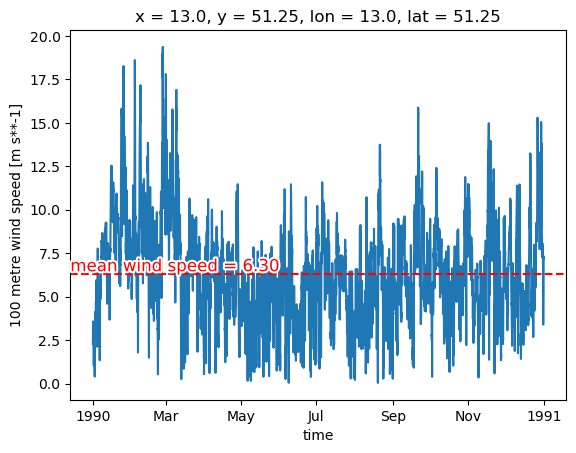

In [6]:
#access the wind speed data of a certain pixel (pixel index)
x=0
y=0
wind_pixel = cutout.data['wnd100m'].isel(x=x, y=y)
# Plot the wind speed over time
wind_pixel.plot.line()
#add mean wind speed
mean_wind_speed_pixel = cutout.data.wnd100m.mean(dim="time").isel(x=x, y=y).values
plt.axhline(y=mean_wind_speed_pixel, color='r', linestyle='--', label=f'mean wind speed')
text = plt.text(x=plt.xlim()[0], y=mean_wind_speed_pixel, s=f'mean wind speed = {mean_wind_speed_pixel:.2f}', 
         color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

# Add stroke effect (white outline)
text.set_path_effects([
    path_effects.withStroke(linewidth=3, foreground="white")
])

In [7]:
#standards for all plots
# Get centroid of each geometry
region['centroid'] = region.geometry.centroid

# Extract central latitude and longitude
region['centroid_lon'] = region.centroid.x
region['centroid_lat'] = region.centroid.y

projection = ccrs.Orthographic(central_longitude=region['centroid_lon'], central_latitude=region['centroid_lat'])
cells = cutout.grid
cutout_bound = gpd.GeoSeries(cells.unary_union)

In [11]:
#interactive plot mean wind speed over whole year for each pixel
wnd100mean = cutout.data.wnd100m.mean(dim="time")

quadmesh_plot = wnd100mean.hvplot.quadmesh(
    "x",
    "y",
    "wnd100m",
    frame_height=500,
    cmap="viridis",
    geo=True,
    tiles="CartoLight",
    alpha=0.8,
    padding=0.5,
    clim=(0, 10),
    title='mean windspeed @100m',
    hover_cols=['x', 'y', 'wnd100m'],  # Include x, y, and wind speed in hover
)

polygon_plot1 = region.hvplot(
    geo=True,
    line_color='red',        # Set color of polygons, e.g., red
    fill_alpha=0,          # Transparency level of polygons
    line_width=1.5,     # Line width for borders of polygons
)



# Overlaying the quadmesh plot with the polygon plot
overlay = quadmesh_plot * polygon_plot1 

# Display the final overlay plot
overlay

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .QuadMesh.I :QuadMesh   [x,y]   (wnd100m,x,y,wnd100m)
   .Polygons.I :Polygons   [Longitude,Latitude]

## cutout and aggregated wind speed over whole country

Text(0.5, 1.0, 'mean windspeed over the whole country')

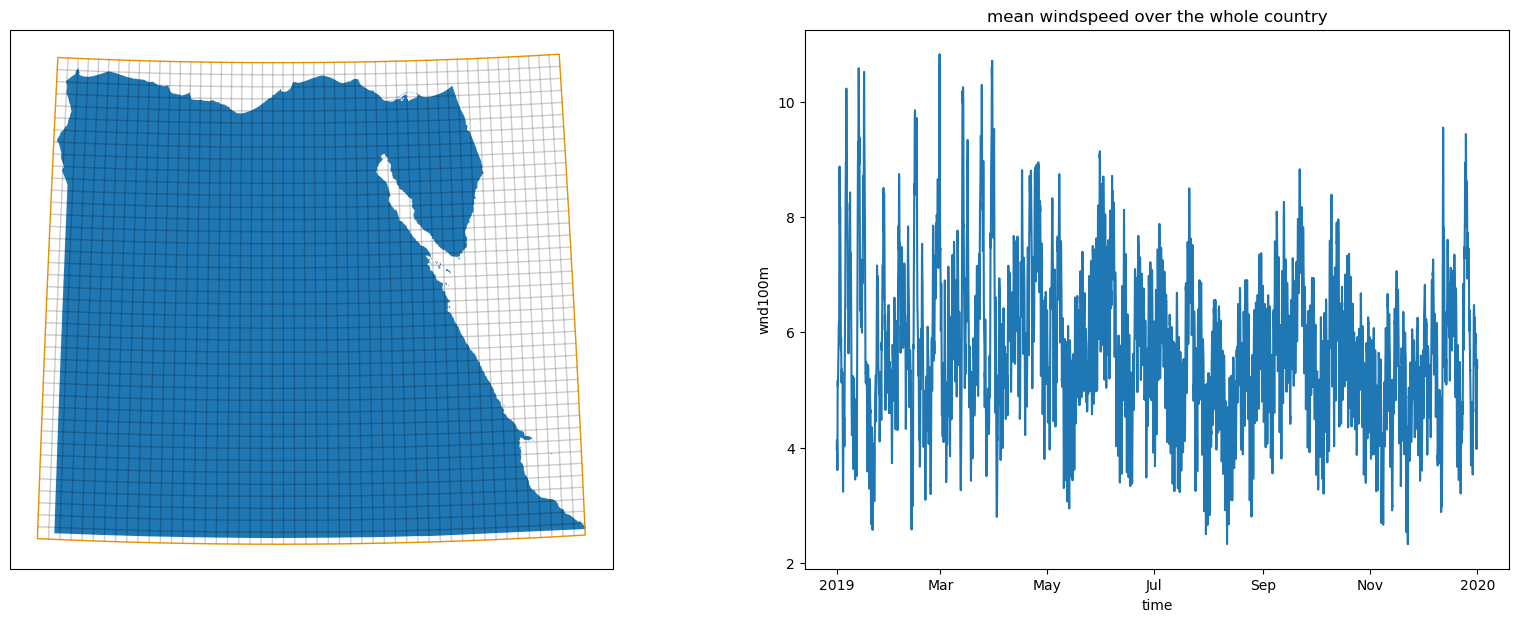

In [8]:
#plot country and mean windspeed over whole country for overview
#cartopy approach --> projections and transformation
fig = plt.figure(figsize=(20, 7))
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
country.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
cutout_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 1])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_title('mean windspeed over the whole country')
#ax1.set_frame_on(False)
#ax1.xaxis.set_visible(False)

## ERA5 weather cells

In [9]:
#interactive plot mean wind speed over whole year for each pixel
wnd100mean = cutout.data.wnd100m.mean(dim="time")



quadmesh_plot = wnd100mean.hvplot.quadmesh(
    "x",
    "y",
    "wnd100m",
    frame_height=500,
    cmap="viridis",
    geo=True,
    tiles="CartoLight",
    alpha=0.8,
    padding=0.5,
    clim=(0, 10),
    title='mean windspeed @100m',
    hover_cols=['x', 'y', 'wnd100m'],  # Include x, y, and wind speed in hover
)

polygon_plot1 = country.hvplot(
    geo=True,
    line_color='red',        # Set color of polygons, e.g., red
    fill_alpha=0,          # Transparency level of polygons
    line_width=1.5,     # Line width for borders of polygons
)

polygon_plot2 = nrea_lands_model_areas.hvplot(
    geo=True,
    line_color='purple',        # Set color of polygons, e.g., red
    fill_alpha=0,          # Transparency level of polygons
    line_width=1.5,     # Line width for borders of polygons
)

# Overlaying the quadmesh plot with the polygon plot
overlay = quadmesh_plot * polygon_plot1 * polygon_plot2

# Display the final overlay plot
overlay

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .QuadMesh.I  :QuadMesh   [x,y]   (wnd100m,x,y,wnd100m)
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

<GeoAxes: xlabel='x', ylabel='y'>

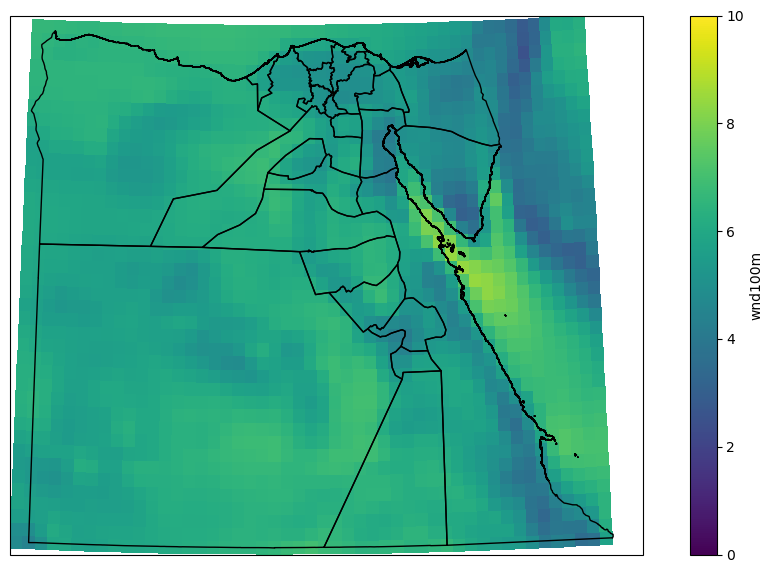

In [10]:
#static plot mean wind speed over whole year for each pixel
fig = plt.figure(figsize=(12, 7))

ax = plt.axes(projection=projection)
wnd100mean.plot(ax=ax, vmin=0, vmax=10, transform=plate())

#shape.to_crs(crs).plot(ax=ax, edgecolor="k", color="None")
model_areas.to_crs(projection.proj4_init).plot(ax=ax, edgecolor="k", color="None")
#shape.plot(ax=ax, edgecolor="k", color="None", transform=plate())

#ax.set_extent([70, 75, 18, 25], crs=crs)

#import cartopy
#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#ax.add_feature(cartopy.feature.LAND, color="cornsilk")
#ax.add_feature(cartopy.feature.OCEAN, color="azure")


# aggregate wind speed timeseries per model area

In [11]:
#check data structure of wind turbine to define helper turbine
atlite.resource.get_windturbineconfig('NREL_ReferenceTurbine_5MW_offshore')

{'V': array([ 0,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 25, 25]),
 'POW': array([0.    , 0.    , 0.0405, 0.1777, 0.4039, 0.7376, 1.1872, 1.7711,
        2.5186, 3.4484, 4.5625, 5.    , 5.    , 0.    ]),
 'hub_height': 90.0,
 'P': 5.0}

In [12]:
#create helper power curve where wind speeds are mapped to themselves 
# the nameplate capacity of this helper_turbine is the max_wind_speed to have values normalized to this wind speed later 
# get like a hourly CF timeseries where 1 equals to the max_wind_speed 
wind_speed = np.arange(0, 31, 1)

helper_turbine = {'V':wind_speed, 'POW':wind_speed, 'hub_height':100, 'P':max_wind_speed}

In [13]:
#check helper turbine
atlite.resource.get_windturbineconfig(helper_turbine)

highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.


{'V': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'POW': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'hub_height': 100,
 'P': 22.435733795166016}

In [14]:
#do the aggregation
windspeed_aggregated_areas = cutout.wind(helper_turbine, per_unit=True, shapes=nrea_lands_model_areas) #, layout=layout) #Vestas_V112_3MW #capacity_factor=True

highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.
INFO:atlite.convert:Convert and aggregate 'wind'.


# Inspect the results 

In [15]:
#turn results into pandas dataframe for easier handling
results = (windspeed_aggregated_areas).to_pandas()#.rename_axis(index="", columns="shapes")
results = results*max_wind_speed
results

model_area,AlBahrAlAhmar,Aswan,AlWadiAlJadid,Matrouh,AsSuways,AlMinya,BaniSuwayf,Benban
time,,,,,,,,
2019-01-01 00:00:00,1.406956,5.038782,3.251938,8.339933,0.731379,4.292737,2.078942,5.124911
2019-01-01 01:00:00,1.622996,4.667865,3.754814,8.450235,0.881676,4.281929,2.305935,4.749235
2019-01-01 02:00:00,1.947615,4.347113,4.290322,8.791371,1.329828,4.285865,2.600517,4.417089
2019-01-01 03:00:00,2.205264,3.941758,4.730117,8.998546,1.896180,4.034179,2.541674,3.993606
2019-01-01 04:00:00,2.318880,3.633766,4.801964,9.254786,2.562317,3.721239,2.416971,3.638213
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,9.841670,7.035297,7.326513,2.994307,2.837371,5.637731,6.078796,7.048192
2019-12-31 20:00:00,9.519251,7.307197,7.312165,3.269933,2.478863,5.888670,5.960298,7.249354
2019-12-31 21:00:00,9.177053,7.268550,7.275816,3.530530,2.369919,6.129526,5.996840,7.178251


Text(429528.0, 6.067681844863938, 'mean wind speed = 6.07')

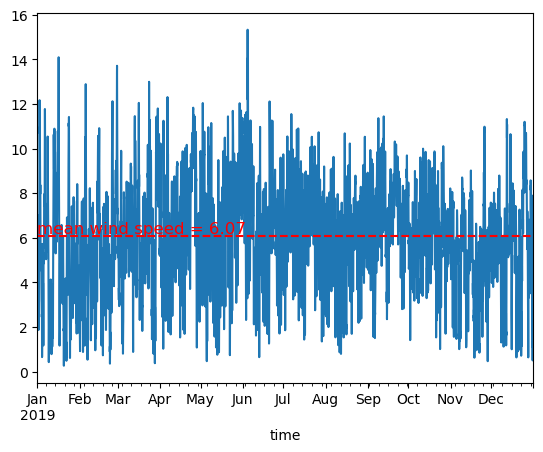

In [16]:
#plot selected region
area = 'BaniSuwayf'
results[area].plot()
#add mean wind speed
mean_wind_speed_area = results[area].mean()
plt.axhline(y=mean_wind_speed_area, color='r', linestyle='--', label=f'mean wind speed')
plt.text(x=plt.xlim()[0], y=mean_wind_speed_area, s=f'mean wind speed = {mean_wind_speed_area:.2f}', 
         color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

In [17]:
#get max wind speeds after aggregation 
print('overall total: ', results.max().max())

results.max()

overall total:  19.014845669299444


model_area
AlBahrAlAhmar    16.222249
Aswan            13.752666
AlWadiAlJadid    12.720810
Matrouh          19.014846
AsSuways         14.747077
AlMinya          13.806745
BaniSuwayf       15.332707
Benban           13.728062
dtype: float64

In [18]:
results.mean()

model_area
AlBahrAlAhmar    7.245818
Aswan            5.619878
AlWadiAlJadid    6.646607
Matrouh          6.474508
AsSuways         4.245186
AlMinya          6.389918
BaniSuwayf       6.067682
Benban           5.585028
dtype: float64

### cap factor

In [25]:
cap_factors = cutout.wind(turbine=atlite.resource.get_oedb_windturbineconfig(name='E-53/800'), per_unit=True, shapes=nrea_lands_model_areas) #nrea_lands_model_areas
cf_wind_df = cap_factors.to_pandas()
cf_wind_df.mean()

INFO:atlite.resource:Searching turbine power curve in OEDB database using name='E-53/800'.
highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.
INFO:atlite.convert:Convert and aggregate 'wind'.


model_area
AlBahrAlAhmar    0.368231
Aswan            0.172378
AlWadiAlJadid    0.269429
Matrouh          0.265239
AsSuways         0.086966
AlMinya          0.247676
BaniSuwayf       0.217694
Benban           0.168720
dtype: float64

# manipulation to obtain BALMOREL year (2019)

In [ ]:
start_date = pd.Timestamp("2019-01-07 00:00") #first monday in 2019

start_date_helper = start_date - pd.Timedelta(days=5)
end_date_helper = start_date - pd.Timedelta(hours=1)

print(start_date)
print(start_date_helper)
print(end_date_helper)

2019-01-07 00:00:00
2019-01-02 00:00:00
2019-01-06 23:00:00


In [83]:
results_balmorel = pd.concat([results.loc[start_date:], results.loc[start_date_helper:end_date_helper]])
results_balmorel

model_area,AlBahrAlAhmar,Aswan,AlWadiAlJadid,Matrouh,AsSuways,AlMinya,BaniSuwayf,Benban
time,,,,,,,,
2019-01-07 00:00:00,7.364312,6.790093,7.876905,11.768206,6.440197,6.096363,5.834314,6.743381
2019-01-07 01:00:00,6.983529,6.837394,7.933647,11.537304,6.342119,5.833305,5.586105,6.800506
2019-01-07 02:00:00,6.824896,6.586160,7.800945,11.343657,6.322120,5.713906,5.544479,6.559978
2019-01-07 03:00:00,6.410600,6.209297,7.527106,11.338975,6.182391,5.637896,5.825583,6.203103
2019-01-07 04:00:00,5.742807,5.888256,7.363666,11.146991,6.212832,5.696330,6.244610,5.887396
...,...,...,...,...,...,...,...,...
2019-01-06 19:00:00,6.632419,6.761683,7.146012,11.266856,6.409337,7.245758,7.474182,6.692479
2019-01-06 20:00:00,6.444818,6.874897,7.222737,11.906682,6.270514,7.316764,7.506325,6.818908
2019-01-06 21:00:00,6.719169,6.858015,7.341342,12.299615,6.318985,7.332520,7.395074,6.815894


In [ ]:
#results_balmorel.to_csv('data\wind_speeds_ERA5.csv')

# Solar

## no tracking

In [196]:
cf_pv_0axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking=None,
    per_unit=True,
)

round(cf_pv_0axis.to_pandas().mean().mean(), 3)

INFO:atlite.convert:Convert and aggregate 'pv'.


0.219

## 1-axis horizontal tracking

In [193]:
cf_pv_1axis_h = cutout.pv(
    panel="CSi",
    orientation={"slope": 0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking="horizontal",
    per_unit=True,
)

round(cf_pv_1axis_h.to_pandas().mean().mean(), 3)

INFO:atlite.convert:Convert and aggregate 'pv'.


0.279

## comparison of time series

In [199]:
cells = cutout.grid
point = cells[(cells["y"] == 25) & (cells["x"] == 25)].index
day = "2019-05-01"

data = [cf_pv_1axis_h, cf_pv_0axis]
labels = [
    "1-axis horizontal tracking",
    "No tracking",
]

## Day profile

<Axes: xlabel='time'>

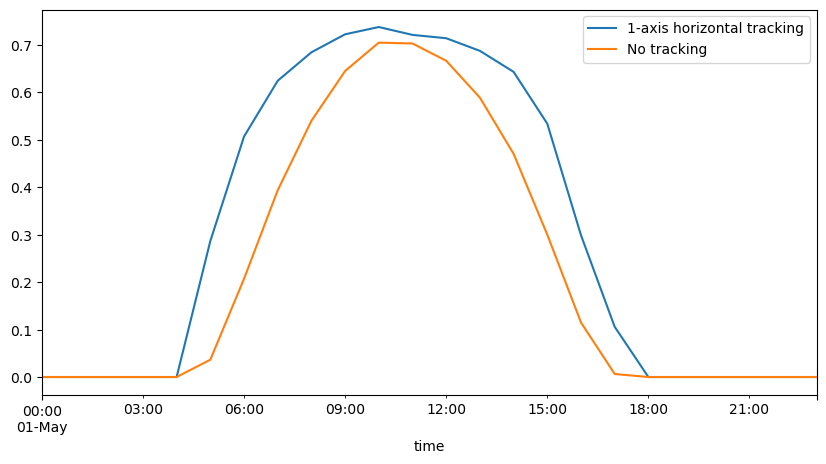

In [201]:
day_profiles = [ds.loc[day, point].squeeze() for ds in data]

df = pd.DataFrame({k: v.to_series() for k, v in zip(labels, day_profiles)})
df.plot(figsize=(10, 5))

## Egypt solar

## fixed solar

In [26]:
cf_pv_0axis_EGY = cutout.pv(
    panel="CSi",
    orientation="latitude_optimal",
    shapes=nrea_lands_model_areas,
    tracking=None,
    per_unit=True,
)

INFO:atlite.convert:Convert and aggregate 'pv'.


In [27]:
cf_pv_0axis_df = (cf_pv_0axis_EGY).to_pandas()
cf_pv_0axis_df

model_area,AlBahrAlAhmar,Aswan,AlWadiAlJadid,Matrouh,AsSuways,AlMinya,BaniSuwayf,Benban
time,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
cf_pv_0axis_df.mean()

model_area
AlBahrAlAhmar    0.219081
Aswan            0.219667
AlWadiAlJadid    0.225135
Matrouh          0.211733
AsSuways         0.217563
AlMinya          0.221495
BaniSuwayf       0.220786
Benban           0.219703
dtype: float64

## horizontal axis tracking

In [38]:
cf_pv_1axis_h_EGY = cutout.pv(
    panel="CSi",
    orientation={"slope": 0, "azimuth": 180.0},
    shapes=nrea_lands_model_areas,
    tracking="horizontal",
    per_unit=True,
)

INFO:atlite.convert:Convert and aggregate 'pv'.


In [39]:
cf_pv_1axis_h_df = (cf_pv_1axis_h_EGY).to_pandas()
cf_pv_1axis_h_df

model_area,AlBahrAlAhmar,Aswan,AlWadiAlJadid,Matrouh,AsSuways,AlMinya,BaniSuwayf,Benban
time,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
cf_pv_1axis_h_df.mean()

model_area
AlBahrAlAhmar    0.279981
Aswan            0.280376
AlWadiAlJadid    0.288676
Matrouh          0.266981
AsSuways         0.278116
AlMinya          0.284227
BaniSuwayf       0.283287
Benban           0.280411
dtype: float64

## evaluation

<Axes: xlabel='time'>

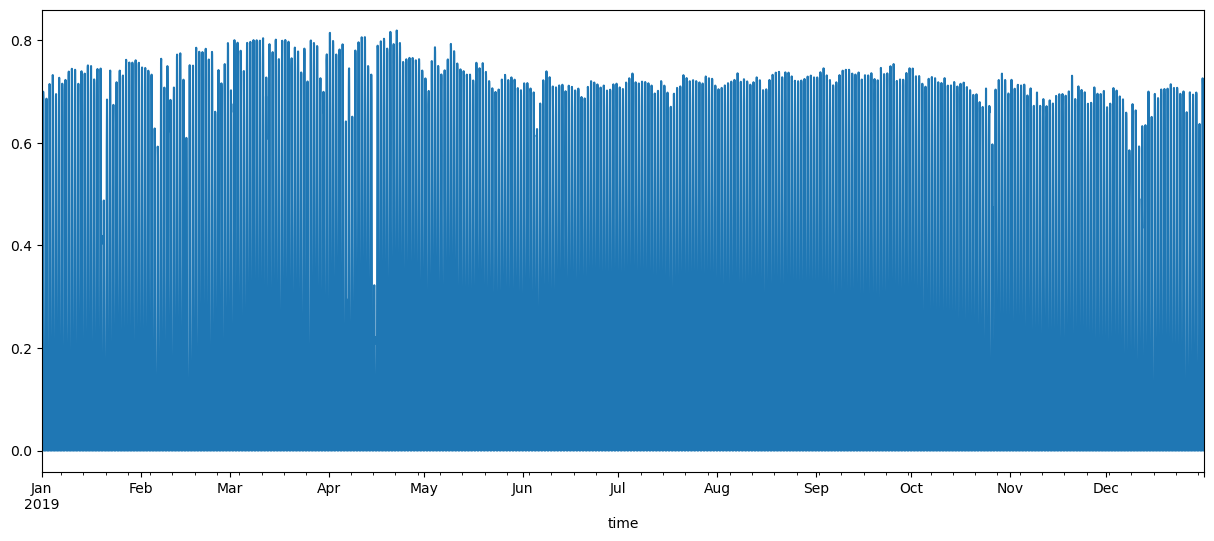

In [190]:
#plot selected region
area = 'BaniSuwayf'
plt.figure(figsize=(15, 6))
cf_pv_0axis_df[area].plot()


<Axes: xlabel='time'>

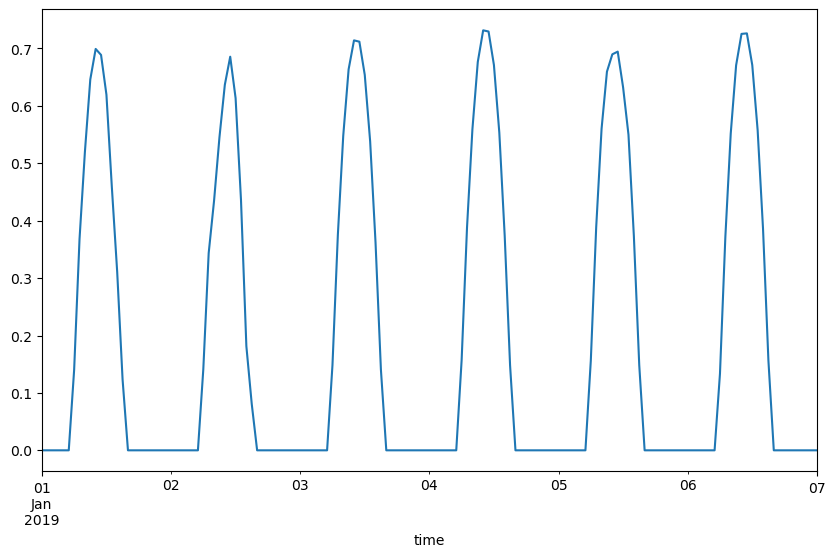

In [191]:
start_date = start_date = pd.to_datetime("2019-01-01")  # Change to the actual start date you want

# Select data for the 7-day range (starting from `start_date` to 6 days later)
selected_week_data = cf_pv_0axis_df[area].loc[start_date:start_date + pd.Timedelta(days=6)]

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the data for the selected week
selected_week_data.plot()


## balmorel year

In [42]:
start_date = pd.Timestamp("2019-01-07 00:00") #first monday in 2019

start_date_helper = start_date - pd.Timedelta(days=5)
end_date_helper = start_date - pd.Timedelta(hours=1)

print(start_date)
print(start_date_helper)
print(end_date_helper)

2019-01-07 00:00:00
2019-01-02 00:00:00
2019-01-06 23:00:00


In [43]:
results_balmorel_pv = pd.concat([cf_pv_0axis_df.loc[start_date:], cf_pv_0axis_df.loc[start_date_helper:end_date_helper]])
results_balmorel_pv

model_area,AlBahrAlAhmar,Aswan,AlWadiAlJadid,Matrouh,AsSuways,AlMinya,BaniSuwayf,Benban
time,,,,,,,,
2019-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2019-01-06 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-06 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-06 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#results_balmorel_pv.to_csv('data\solar-pv-fixed_ERA5.csv')

In [45]:
results_balmorel_pv_h = pd.concat([cf_pv_1axis_h_df.loc[start_date:], cf_pv_1axis_h_df.loc[start_date_helper:end_date_helper]])
results_balmorel_pv_h

model_area,AlBahrAlAhmar,Aswan,AlWadiAlJadid,Matrouh,AsSuways,AlMinya,BaniSuwayf,Benban
time,,,,,,,,
2019-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2019-01-06 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-06 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-06 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#results_balmorel_pv_h.to_csv('data\solar-pv-horizontal_ERA5.csv')